In [1]:
#도구 준비

import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
#segmentation 모델 준비(deeplab)

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
#사전 학습된 weight 불러오기

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [4]:
#데이터 준비

self_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/self.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
self_orig = cv2.imread(self_path) 
print (self_orig.shape)

self1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/self1.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
self1_orig = cv2.imread(self1_path) 
print (self1_orig.shape)

cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
cat_orig = cv2.imread(cat_path) 
print (cat_orig.shape)

back_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/back.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
back_orig = cv2.imread(back_path)
back_resize = cv2.resize(back_orig, dsize=(960, 540), interpolation=cv2.INTER_AREA)
print (back_resize.shape)

(540, 960, 3)
(540, 960, 3)
(846, 564, 3)
(540, 960, 3)


In [5]:
#네트워크에 입력

self_resized, self_seg_map = MODEL.run(self_orig)
print (self_orig.shape, self_resized.shape, self_seg_map.max())
self1_resized, self1_seg_map = MODEL.run(self1_orig)
print (self1_orig.shape, self1_resized.shape, self1_seg_map.max())
cat_resized, cat_seg_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, cat_seg_map.max())

(540, 960, 3) (288, 513, 3) 15
(540, 960, 3) (288, 513, 3) 15
(846, 564, 3) (513, 342, 3) 8


In [6]:
#deeplab의 라벨 확인
# 사람 15 고양이 8

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

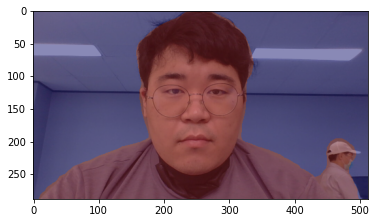

In [7]:
#마스크 시각화

self_show = self_resized.copy()
self_seg_map = np.where(self_seg_map == 15, 15, 0) # 예측 중 사람만 추출
self_mask = self_seg_map * (255/self_seg_map.max()) # 255 normalization
self_mask = self_mask.astype(np.uint8)
color_self_mask = cv2.applyColorMap(self_mask, cv2.COLORMAP_JET)
self_show = cv2.addWeighted(self_show, 0.6, color_self_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(self_show, cv2.COLOR_BGR2RGB))
plt.show()

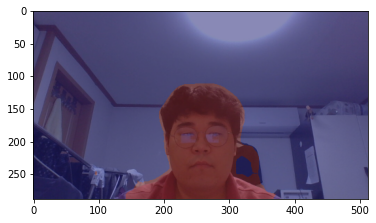

In [8]:
self1_show = self1_resized.copy()
self1_seg_map = np.where(self1_seg_map == 15, 15, 0) # 예측 중 사람만 추출
self1_mask = self1_seg_map * (255/self1_seg_map.max()) # 255 normalization
self1_mask = self1_mask.astype(np.uint8)
color_self1_mask = cv2.applyColorMap(self1_mask, cv2.COLORMAP_JET)
self1_show = cv2.addWeighted(self1_show, 0.6, color_self1_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(self1_show, cv2.COLOR_BGR2RGB))
plt.show()

## 인물 사진에서 문제점 발생

첫번째 사진에서는 사람 카테고리의 오브젝트는 분명하게 구분했지만 instance segmentation이 진행되지 않은 것을 확인할 수 있다.
두번째 사진에서는 배경의 검은 색 옷이 사람으로 인식되는 문제가 발생하였다.

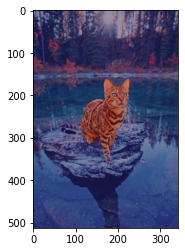

In [9]:
cat_show = cat_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 사람만 추출
cat_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
color_cat_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.6, color_cat_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

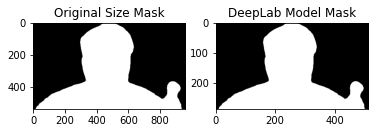

In [10]:
#마스크를 original size로 복원

self_mask_up = cv2.resize(self_mask, self_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, self_mask_up = cv2.threshold(self_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(self_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(self_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

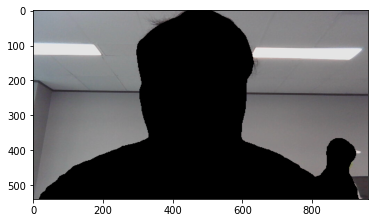

In [11]:
#배경 추출

self_mask_color = cv2.cvtColor(self_mask_up, cv2.COLOR_GRAY2BGR)
self_bg_mask = cv2.bitwise_not(self_mask_color)
self_bg = cv2.bitwise_and(self_orig, self_bg_mask)
plt.imshow(self_bg)
plt.show()

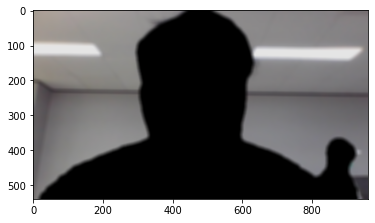

In [12]:
#블러처리

self_bg_blur = cv2.blur(self_bg, (13,13))
plt.imshow(cv2.cvtColor(self_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

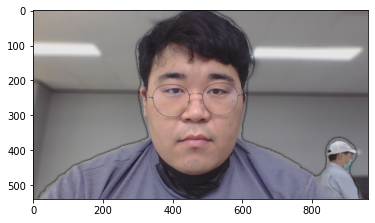

In [13]:
#배경 이미지와 대상 이미지 합치기

self_concat = np.where(self_mask_color==255, self_orig, self_bg_blur)
plt.imshow(cv2.cvtColor(self_concat, cv2.COLOR_BGR2RGB))
plt.show()

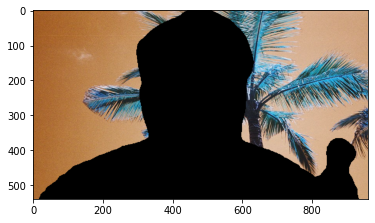

In [14]:
#바꿀 배경 처리
back_bg = cv2.bitwise_and(back_resize, self_bg_mask)
plt.imshow(back_bg)
plt.show()

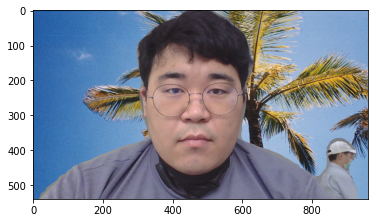

In [15]:
#다른 배경으로 바꾸기
another_concat_back = np.where(self_mask_color==255, self_orig, back_bg)
plt.imshow(cv2.cvtColor(another_concat_back, cv2.COLOR_BGR2RGB))
plt.show()

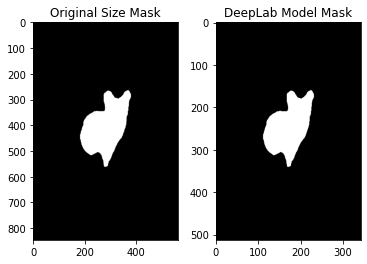

In [16]:
#고양이

cat_mask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

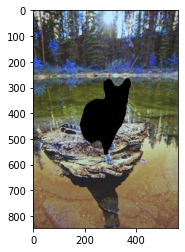

In [17]:
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg = cv2.bitwise_and(cat_orig, cat_bg_mask)
plt.imshow(cat_bg)
plt.show()

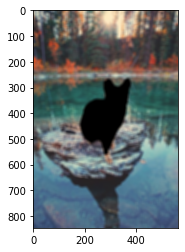

In [18]:
cat_bg_blur = cv2.blur(cat_bg, (13,13))
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

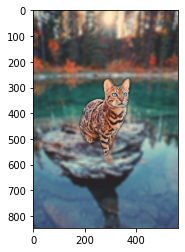

In [19]:
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 총평

## 발생한 문제점
문제 1
사람 오브젝트는 분명하게 인식했으나 각 객체별 구분(instance segmentation)이 없다.

문제 2
검은색 물체를 옆에 두고 인위적으로 해당 문제를 재현하자 해당 부분이 사람으로 인식되는 문제가 발생하였다.
여러번 시도 결과 머리 근처에 검은색 오브젝트가 있을 경우에 비슷한 문제가 발생하는 것을 확인할 수 있었다.

## 해결책
문제 1
해당 문제는 deeplab 모델 추론을 픽셀단위로 진행되었기에 발생한 문제로 Mask RNN과 같이 객체 구분까지 진행하는 모델을 필요로 한다.

문제 2
각도가 다른 데이터를 제공함으로서 오브젝트의 깊이를 추론하고 오브젝트간 구분하는 방법을 사용하거나 agmentation 등의 방법을 활용하여 fine-tuning을 해줌으로서 일정 수준까지 해결할 수 있다.